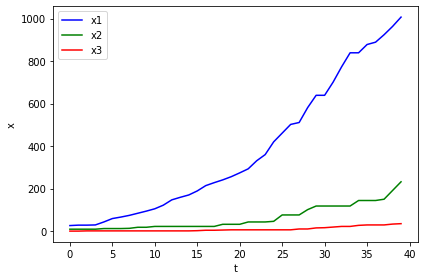

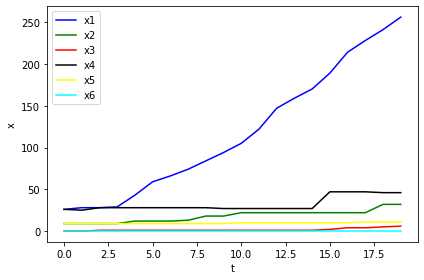

In [11]:
# particlefilterで感染症モデルのパラメータ推定
# Sとほかのパラメータの分散の値が離れすぎて共分散行列が正則にならないとみなされてるっぽい

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import kal_python as kal

# 各種パラメータ
beta = 2.2/1*1000*5
sigma = 1.0/4.6/100/10000*2
xi = 1.0/280/1000
gamma = 1.0/5.0/100*2
delta = 0.01/10
N = 10.0 ** 9 # 人口
h = 1 # 1サイクルあたりの日数
dt = 1
T = 67 # 日数

# x = np.array([s,sigma,beta_gamma,xi,delta])
x0 = np.array([N*0.9,sigma,beta,gamma,xi,delta])# 初期値
y0 = np.array([26,9,0])

# 状態方程式
class dss_covid19:
    def __init__(self,x0,y0):
        self.x_pre = copy.deepcopy(x0)
        self.y_pre = copy.deepcopy(y0)
        
    def update(self,x):
        I,R,D = self.y_pre
        x_ = np.zeros(6)
        x_[0] = x[0] - x[2]*dt/N*x[0]*I + xi*dt*R
        x_[1] = x[1]
        x_[2] = x[2]
        x_[3] = x[3]
        x_[4] = x[4]
        x_[5] = x[5]
        self.x_pre = copy.deepcopy(x_)
        return x_
    
    def observation(self,x):
        I,R,D = self.y_pre
        y_ = np.zeros(3)
        y_[0] = I + dt*x[1]*(N-x[0]-I-R-D) - (x[3]+x[5])*dt*I
        y_[1] = R + x[3]*dt*I - x[4]*dt*R
        y_[2] = D + dt*x[5]*I
        self.y_pre = copy.deepcopy(y_)
        return y_

#パーティクルフィルタ用のパラメータ
covx = np.diag([1.0,0.0001,6.0,0.0001,0.0001,0.0001])**2
covy = np.diag([100,10,10])**2
Np = 1000 #粒子の数
corona = dss_covid19(x0,y0)
pf = kal.ParticleFilter(copy.deepcopy(corona),copy.deepcopy(x0),copy.deepcopy(y0),Np,covx,covy)

# データ読み込み
t = np.arange(0,T,1)
data = pd.read_csv('time_series_covid19/time_series_covid19_JPN.csv',header=None)
y = np.array(data)
# 描画
fig = kal.t_x_plot(3,40)
fig.show(t[:40],y[:,:40])
y_data = copy.deepcopy(y)

# パラメータ推定
x = np.zeros((6,T))
x[:,0]=x0
y[:,0]=y0
for i in range(1,T):
#    x[:,i] = corona.update(x[:,i-1])
#    y[:,i] = corona.observation(x[:,i])
    x[:,i] = pf.update(y[:,i])
    #print(x[:,i])
for i in range(1,T):
    y[:,i] = corona.observation(x[:,i])
tt = t[0:20]
yy =np.concatenate([y_data, y])
yy_p = yy[:,:20].copy()
fig = kal.t_x_plot(6,20)
fig.show(tt,yy_p)

In [7]:
tt

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])